In [5]:
## General Libraries
import numpy as np
import matplotlib.pyplot as plt
from Utilities import log_progress

# Environment Library
from Vissim_env_class import environment

# Agent Libraries
from Actor_critic_class import ACAgent
from DQNAgents import DQNAgent

# Network Specific Libraries
from Balance_Functions import balance_dictionary

# Plotting
%matplotlib inline

In [6]:
## Temporary Executive Control
agent_type = 'DQN'
vissim_working_directory = 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim\\'




# VISSIM CONTROL
model_name  = 'Balance'
sim_length = 3601
timesteps_per_second = 1
Random_Seed = 42
Balance_dictionary = balance_dictionary(agent_type)


In [7]:
## DQN Hyperaramenters
episodes = 2
copy_weights_frequency = 5

PER_activated = False
memory_size = 100
batch_size = 64

gamma = 0.95
alpha = 0.005

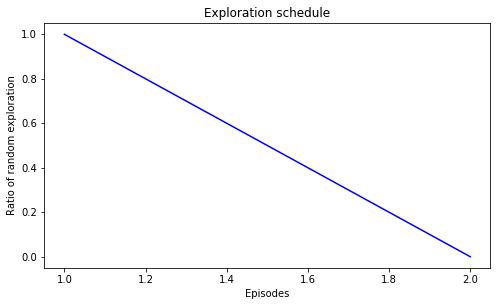

In [12]:
# Exploration Schedule ("linear" or "geometric")
exploration_schedule = "geometric"

def choose_schedule(exploration_schedule):
    epsilon_start = 1
    epsilon_end   = 0.001
    if exploration_schedule == "linear":
        epsilon_decay = 1.2*(epsilon_end - epsilon_start)/(episodes-1)
        epsilon_sequence = [1 + epsilon_decay * entry for entry in range(episodes+1)]
        epsilon_sequence = [0 if entry < 0 else entry for entry in epsilon_sequence]
    elif exploration_schedule == "geometric":
        epsilon_decay = np.power(epsilon_end/epsilon_start, 1./(episodes-1)) # Geometric decay
        epsilon_sequence = [epsilon_start * epsilon_decay ** entry for entry in range(episodes+1)]
    elif exploration_schedule == "entropy":
        pass
    else:
        print("ERROR: Unrecognized choice of exploration schedule.")
        
    # Plotting exploration schedule
    plt.figure(figsize=(8,4.5))
    x_series = np.array(range(1,episodes+1))
    y_series = epsilon_sequence[0:episodes]
    plt.plot(x_series, y_series, '-b')
    plt.xlabel('Episodes')
    plt.ylabel('Ratio of random exploration')
    plt.title('Exploration schedule')
    plt.show()
    return(epsilon_sequence)

epsilon_sequence = choose_schedule(exploration_schedule)

In [10]:
env = environment(model_name, vissim_working_directory, sim_length, Balance_dictionary,\
          Random_Seed, mode = 'training', delete_results = True, verbose = True)

Working Directory set to: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Attempting to load Model File: Balance.inpx ...
Model File load process successful.
Simulation length set to 3601 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                COM SETUP COMPLETE                   *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 42
Deploying Network Parser...
Successful Network Crawl: Identified SignalControllers, Links and Lanes.

Setting Simulation mode to: training

Starting Deployments of Signal Control 

In [13]:
Agents = [DQNAgent(env.SCUs[idx].state_size[0], len(env.SCUs[idx].compatible_actions),\
         ID, memory_size, gamma, epsilon_sequence[0], alpha,copy_weights_frequency, PER_activated,\
         DoubleDQN = True if agent_type == ("DDQN" or "DuelingDDQN") else False,\
         Dueling = False if agent_type == ("DQN" or "DDQN") else True) for idx, ID in enumerate(env.npa.signal_controllers_ids)] 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Deploying instance of Standard Deep Q Learning Agent(s) at intersection 0
Deploying instance of Standard Deep Q Learning Agent(s) at intersection 1
Deploying instance of Standard Deep Q Learning Agent(s) at intersection 2
Deploying instance of Standard Deep Q Learning Agent(s) at intersection 3
Deploying instance of Standard Deep Q Learning Agent(s) at intersection 4
Deploying instance of Standard Deep Q Learning Agent(s) at intersection 5
Deploying instance of Standard Deep Q Learning Agent(s) at intersection 6
Deploying instance of Standard Deep Q Learning Agent(s) at intersection 7
Deploying instance of Standard Deep Q Learning Agent(s) at intersection 8
Deploying instance of Standard Deep Q Learning Agent(s) at intersection 9
Deploying instance of Standard Deep Q Learning Agent(s) at intersection 10
Deploying instance of Standard Deep Q Learning Agent(s) at inters

In [ ]:
# Get Initial State
start_state = env.get_state()
# Get Initial Set of Actions
actions = {}
for idx, s in start_state.items():
            actions[idx] = int(Agents[idx].choose_action(s))

## Main loop
# For each decision
for i in range(80):
    SARSDs = env.step_to_next_action(actions)
    actions = dict()
    for idx , sarsd in SARSDs.items():
        s,a,r,ns,d = sarsd
        
        # Each agent commits to memory the previous cycle.
        Agents[idx].remember(s,a,r,ns,d)
        
        # Only in the ActorCritic case, we can do online learning
        if agent_type == "AC":
            if len(Agents[idx].memory) >= Agents[idx].n_step_size :
                Agents[idx].learn() 
            
        # in order to find the next action you need to evaluate the "next_state" because it is the current state of the simulator
        actions[idx] = int(Agents[idx].choose_action(ns))
        #print(actions)
        
        
        if agent_type == "AC":
        ## This is to be converted into an agent's method.
            if (i+1)%reduce_entropy_every == 0:
                if Agents[idx].params['entropy'] >= entropy_threshold :
                    Agents[idx].reduce_entropy()
                    print ("Agent {} : Entropy reduced to {} " .format(idx, Agents[idx].params['entropy']))
        
    # For the saving , monitoring of the agent 
    if env.done :
        # Here goes all the metrics summary stuff.
        print('patate')
        env.reset()
        
        
        # Only for AC
        for idx, agent in enumerate(Agents):
            predicted_values, true_values, proba0, probas = agent.value_check(horizon, n_sample)
            print ("Agent {} : Predicted Values and True Return : \n {} \n {}" .format(idx, predicted_values, true_values))
            print ("Agent {} : Proba distribution on those states : \n {}" .format(idx, probas))
            print ("Agent {} : Proba distribution on the 0 state : \n {}" .format(idx, proba0))
            agent.reset()
                    
        
        for idx, s in start_state.items():
            actions[idx] = Agents[idx].choose_action(s)

In [21]:
# For some unknown reason  nothing is printing in this cell...
start_state = env.get_state()
actions = {}
for idx, s in start_state.items():
            actions[idx] = int(Agents[idx].choose_action(s))

In [15]:
SARSDs = env.step_to_next_action(actions)

In [25]:
env.Vissim.Simulation.AttValue("RandSeed")
env.Vissim.Simulation.SetAttValue("RandSeed",1)

com_error: (-2147352567, 'Exception occurred.', (0, 'VISSIM.Vissim.1100', 'AttValue failed: This action cannot be performed during simulation.', None, 0, -2147352567), None)

In [18]:
for idx, item in SARSDs.items():
    print(idx, item)

0 [array([[0., 0., 0., 0., 0., 0., 0., 0.]]), 0, -0.0, array([[0., 0., 0., 0., 0., 0., 0., 0.]]), False]
1 [array([[0., 0., 0., 0., 0., 0., 0., 0.]]), 0, -0.0, array([[0., 0., 0., 0., 0., 0., 0., 0.]]), False]
2 [array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 0, -0.0, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), False]
3 [array([[0., 0., 0., 0., 0., 0., 0., 0.]]), 0, -0.0, array([[0., 0., 0., 0., 0., 0., 0., 0.]]), False]
4 [array([[0., 0., 0., 0., 0., 0.]]), 0, -0.0, array([[0., 0., 0., 0., 0., 0.]]), False]
5 [array([[0., 0., 0.]]), 0, -0.0, array([[0., 0., 0.]]), False]
6 [array([[0., 0., 0., 0., 0., 0.]]), 0, -0.0, array([[0., 0., 0., 0., 0., 0.]]), False]
7 [array([[0., 0., 0., 0., 0., 0., 0.]]), 0, -0.0, array([[0., 0., 0., 0., 0., 0., 0.]]), False]
8 [array([[0., 0., 0.]]), 0, -0.0, array([[0., 0., 0.]]), False]
9 [array([[0., 0., 0., 0.]]), 0, -0.0, array([[0., 0., 0., 0.]]), False]
10 [array([[0., 0., 0., 0.]]), 0, -0.0, array([[0., 0.

In [26]:
env.reset()

NameError: name 'Stop_Simulation' is not defined